In [1]:
# %%sh
# http_proxy=http://10.245.5.249:8080
# export http_proxy
# https_proxy=https://10.245.5.249:8080
# export https_proxy

# pip install kmodes
# # pip install gcsfs
# # pip install factor_analyzer
# # pip install hdbscan
# # pip install numpy==1.16.1
# # pip install seaborn --upgrade

In [2]:
import csv
import math
import warnings
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:.2f}'.format

In [3]:
df_ads_v1 = pd.read_csv('gs://aes-datahub-0002-customerservice-curated/CovidTest/res_cust_v8.2_07202020.csv', index_col=0)
print(df_ads_v1.shape)

(239200, 15)


In [4]:
df_ads_v1.head()

,BALANCE,SERVICE_CENTER,BILL_UNIT,Acc_Disconnect_Count,Acc_Letter_Count,Acc_Due_Count_1,Acc_Due_Count_2,Acc_Due_Count_3,Acc_Personal_Contact_count,Acc_Due_Count,CustAcc_Flag,Covid,Onset,precovid,Pa_Opted_Flag
0,75.00,WLM,15a,0,0,2,0,0,0,2,SingleAcc,0,0,2,False
1,8.32,WLM,8a,0,0,0,0,0,0,0,MultiAcc,0,0,0,False
2,8.49,WLM,8a,0,0,0,0,0,0,0,MultiAcc,0,0,0,False
3,9.45,WLM,8a,0,0,0,0,0,0,0,MultiAcc,0,0,0,False
4,9.88,WLM,8a,0,0,0,0,0,0,0,MultiAcc,0,0,0,False


## Correlation Matrix 
A correlation matrix is a table showing correlation coefficients between variables. <br>
Each cell in the table shows the correlation between two variables. <br>
A correlation matrix is used to summarize data, as an input into a more advanced analysis, and as a diagnostic for advanced analyses. <br>

In [5]:
numeric_cols = list(df_ads_v1.select_dtypes(include=[np.number]).columns)
corr_plot_numerical= df_ads_v1[numeric_cols]

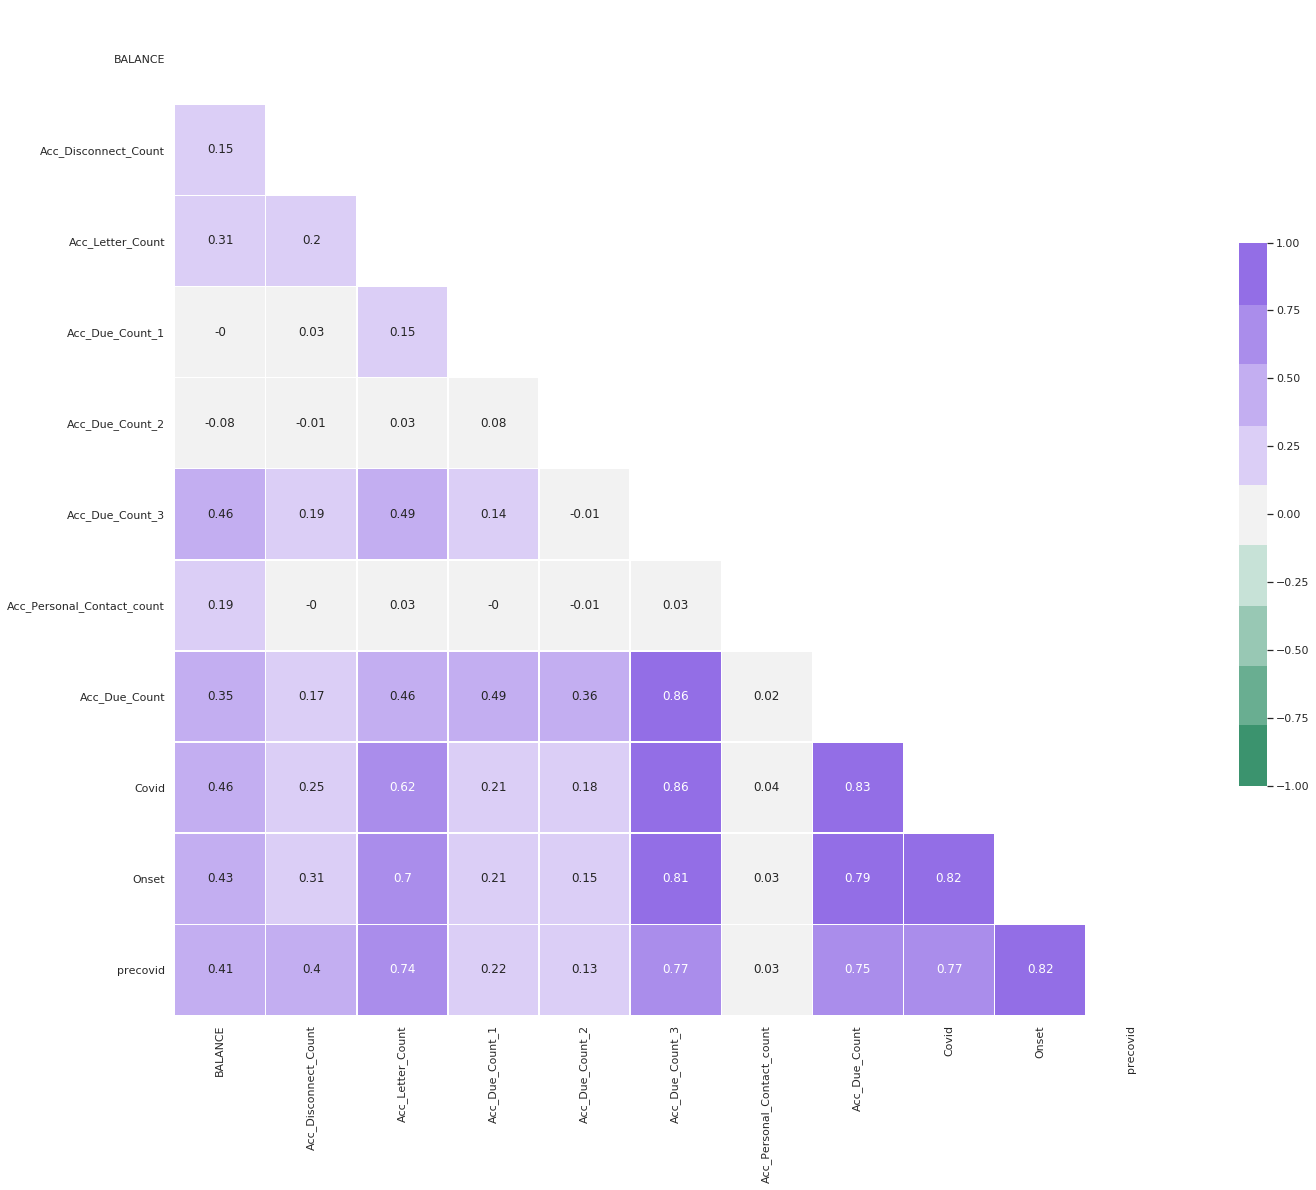

In [6]:
sns.set(style="white")

# Compute the correlation matrix
corr = corr_plot_numerical.corr()
corr = corr.round(2)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 10))

# Generate a custom diverging colormap
# cmap = sns.diverging._palette(220, 10, as_cmap=True)
cmap = sns.diverging_palette(150, 275, s=80, l=55, n=9)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
            annot = True, vmin=-1)

## VIF
In statistics, the variance inflation factor (VIF) is the quotient of the variance in a model with multiple terms by the variance of a model with one term alone. <br>
It quantifies the severity of multicollinearity in an ordinary least squares regression analysis. <br>
It provides an index that measures how much the variance (the square of the estimate's standard deviation) of an estimated regression coefficient is increased because of collinearity. <br>
Cuthbert Daniel claims to have invented the concept behind the variance inflation factor, but did not come up with the name. <br>

In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = add_constant(corr_plot_numerical)
vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
type(vif)
df_vif = pd.DataFrame({'Feature': vif.index, 'VIF_SCORES': vif.values})
df_vif[df_vif.VIF_SCORES<=10]

,Feature,VIF_SCORES
0,const,1.85
1,BALANCE,1.41
2,Acc_Disconnect_Count,1.43
3,Acc_Letter_Count,3.63
7,Acc_Personal_Contact_count,1.04
9,Covid,6.03
10,Onset,5.48
11,precovid,6.03


In [10]:
from scipy.stats import zscore
numeric_cols = df_ads_v1.select_dtypes(include=[np.number]).columns
df_ws_zscore = df_ads_v1[numeric_cols].apply(zscore)
df_ws_zscore.head()

,BALANCE,Acc_Disconnect_Count,Acc_Letter_Count,Acc_Due_Count_1,Acc_Due_Count_2,Acc_Due_Count_3,Acc_Personal_Contact_count,Acc_Due_Count,Covid,Onset,precovid
0,-0.28,-0.16,-0.48,1.40,-0.60,-0.53,-0.02,-0.16,-0.63,-0.63,-0.39
1,-0.45,-0.16,-0.48,-0.36,-0.60,-0.53,-0.02,-0.76,-0.63,-0.63,-0.64
2,-0.45,-0.16,-0.48,-0.36,-0.60,-0.53,-0.02,-0.76,-0.63,-0.63,-0.64
3,-0.45,-0.16,-0.48,-0.36,-0.60,-0.53,-0.02,-0.76,-0.63,-0.63,-0.64
4,-0.45,-0.16,-0.48,-0.36,-0.60,-0.53,-0.02,-0.76,-0.63,-0.63,-0.64


In [14]:
standard_data = pd.merge(df_ws_zscore, df_ads_v1, left_index=True, right_index=True, suffixes=('','_y'))
standard_data = standard_data[standard_data.columns.drop(list(standard_data.filter(regex='_y')))]
standard_data.head()

,BALANCE,Acc_Disconnect_Count,Acc_Letter_Count,Acc_Due_Count_1,Acc_Due_Count_2,Acc_Due_Count_3,Acc_Personal_Contact_count,Acc_Due_Count,Covid,Onset,precovid,SERVICE_CENTER,BILL_UNIT,CustAcc_Flag,Pa_Opted_Flag
0,-0.28,-0.16,-0.48,1.40,-0.60,-0.53,-0.02,-0.16,-0.63,-0.63,-0.39,WLM,15a,SingleAcc,False
1,-0.45,-0.16,-0.48,-0.36,-0.60,-0.53,-0.02,-0.76,-0.63,-0.63,-0.64,WLM,8a,MultiAcc,False
2,-0.45,-0.16,-0.48,-0.36,-0.60,-0.53,-0.02,-0.76,-0.63,-0.63,-0.64,WLM,8a,MultiAcc,False
3,-0.45,-0.16,-0.48,-0.36,-0.60,-0.53,-0.02,-0.76,-0.63,-0.63,-0.64,WLM,8a,MultiAcc,False
4,-0.45,-0.16,-0.48,-0.36,-0.60,-0.53,-0.02,-0.76,-0.63,-0.63,-0.64,WLM,8a,MultiAcc,False


In [15]:
print(standard_data.dtypes)

BALANCE                       float64
Acc_Disconnect_Count          float64
Acc_Letter_Count              float64
Acc_Due_Count_1               float64
Acc_Due_Count_2               float64
Acc_Due_Count_3               float64
Acc_Personal_Contact_count    float64
Acc_Due_Count                 float64
Covid                         float64
Onset                         float64
precovid                      float64
SERVICE_CENTER                 object
BILL_UNIT                      object
CustAcc_Flag                   object
Pa_Opted_Flag                    bool
dtype: object


### **K-prototypes**
Calculating means limits their use to numeric data. <br>
This is where K-Prototype shines. <br>
When applied to numeric data the algorithm is identical to k-means. <br>
For categorical data algorithm uses a simple matching dissimilarity measure. , replaces the means of clusters with modes, and uses a frequency-based method to. <br>

In [ ]:
from kmodes.kprototypes import KPrototypes
ks = range(3, 13)
cost = []
for k in ks:
    model = KPrototypes(n_clusters=k, init='Cao')
    
    # Fit model to samples
    model.fit(standard_data.iloc[:,:], categorical=[11,12,13,14])
    
    # Append the inertia to the list of inertias
    cost.append(kproto.cost_)

plt.figure(figsize=(20,10))
plt.title('Elbow Method Graph')
plt.plot(ks, cost, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

### **The Silhouette Method**
The silhouette value measures how similar a point is to its own cluster (cohesion) compared to other clusters (separation).

In [ ]:
from sklearn.metrics import silhouette_score

sil = []
kmax = 12

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
    kmeans = KPrototypes(n_clusters = k, init='Cao').fit(standard_data, categorical=[1,2,10,14])
    labels = KPrototypes.labels_
    score = silhouette_score(df_ws_v2, labels, metric = 'euclidean')
    sil.append(score)
    print("For n_clusters = {}, silhouette score is {})".format(k, round(score,4)))